<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Desafio N°3
## Modelo de lenguaje con tokenización por caracteres

Valentín Pertierra



### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install ebooklib
!pip install beautifulsoup4 lxml


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Datos
Se utilizara como dataset el libro de "El señor de los anillos".

In [3]:
import platform
import os
from ebooklib import epub, ITEM_DOCUMENT
from bs4 import BeautifulSoup

if os.access('El Señor de los Anillos.epub', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl https://raw.githubusercontent.com/valentinPertierra/LSE_NLP/1ac532f1560c538b9e24b3771e14c5fed71146d9/Desafio%202/El%20Se%C3%B1or%20de%20los%20Anillos.epub -o LOTR.epub
    else:
        !wget LOTR.epub https://raw.githubusercontent.com/valentinPertierra/LSE_NLP/1ac532f1560c538b9e24b3771e14c5fed71146d9/Desafio%202/El%20Se%C3%B1or%20de%20los%20Anillos.epub
else:
    print("El dataset ya se encuentra descargado")


book = epub.read_epub('El Señor de los Anillos.epub')

El dataset ya se encuentra descargado


C:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\ebooklib\epub.py:1395: UserWarning: In the future version we will turn default option ignore_ncx to True.
  warnings.warn('In the future version we will turn default option ignore_ncx to True.')
C:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\ebooklib\epub.py:1423: FutureWarning: This search incorrectly ignores the root element, and will be fixed in a future version.  If you rely on the current behaviour, change it to './/xmlns:rootfile[@media-type]'
  for root_file in tree.findall('//xmlns:rootfile[@media-type]', namespaces={'xmlns': NAMESPACES['CONTAINERNS']}):


In [4]:
# Obtengo el texto del epub
article_text = ''

for item in book.get_items():
  if item.get_type() == ITEM_DOCUMENT:
    content = item.get_content()
    soup = BeautifulSoup(content, 'html.parser')
    article_text += soup.get_text()

# tranformo a minusculas
article_text = article_text.lower()

# elimino los salto de lineas
article_text = article_text.replace('\n','')

# Reduzco el tamaño del corpus porque al momento del entrenamiento me quedo sin RAM
article_text = article_text[0:400000]
print(len(article_text))

400000


In [5]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

'\xa0el señor de los anillos es una novela, obra cumbre del escritor john ronald reuel tolkien, ambientada en un mundo fantástico llamado la tierra media hacia el final de su tercera edad. el título hace referencia a sauron, el señor oscuro de mordor, principal villano de la historia, creador del anillo único que utilizó para controlar el poder de los demás anillos. el señor de los anillos constituye la continuación de un libro anterior de tolkien, el hobbit, que cuenta la historia de cómo el anillo del poder pasa a las manos de bilbo bolsón, el tío de frodo bolsón. en un nivel más profundo, constituye la continuación de otro libro llamado el silmarillion, que habla de la creación de la tierra media y de todas las criaturas que en ella habitan, así como del primer señor oscuro, maestro de sauron, y de las luchas por los silmarils.el señor de los anillos narra las aventuras de un grupo de seres: (elfos, hobbits, enanos, humanos), que forman la comunidad del anillo en su intento por dest

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [6]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [7]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [8]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [9]:
print(chars_vocab)

{'»', 'd', 'b', 'f', ']', '¿', 'n', 'i', 'o', 'w', '[', '0', 'g', 'y', '1', 'v', '5', 'x', 'c', '9', 'ü', 'í', "'", 'r', '7', 'p', '—', ',', '4', '8', ';', 'q', '"', 'ñ', 'u', 'e', 't', 'l', 's', '\xa0', 'j', '2', '3', '-', '¡', '6', 'ó', 'a', '(', 'z', ')', 'è', '\r', '!', 'û', 'é', ' ', 'k', '«', ':', 'm', 'á', 'ú', '?', 'h', '.'}


In [10]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

66

In [11]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [12]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [13]:
tokenized_text[:10]

[39, 35, 37, 56, 38, 35, 33, 8, 23, 56]

### Organizando y estructurando el dataset

In [14]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [15]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [16]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [17]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [18]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [19]:
X.shape

(359900, 100)

In [20]:
X[0,:10]

array([39, 35, 37, 56, 38, 35, 33,  8, 23, 56])

In [21]:
y[0,:10]

array([35, 37, 56, 38, 35, 33,  8, 23, 56,  1])

In [22]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

Funcion de callback utilizada para el entrenamiento de todos los modelos

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [23]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5, model_file='model.keras'):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience
      self.model_file = model_file
      self.history_ppl = history_ppl

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(self.model_file)
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Modelo SimpleRNN

In [24]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [25]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 66)         0         
 ibuted)                                                         
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 200)         53400     
                                                                 
 dense (Dense)               (None, None, 66)          13266     
                                                                 
Total params: 66,666
Trainable params: 66,666
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento

In [28]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
srnn_model_file = 'srnn_model.keras'

hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, history_ppl, model_file=srnn_model_file)], batch_size=256)

Epoch 1/20
1406/1406 [==============================] - ETA: 0s - loss: 2.1048
 mean perplexity: 5.926172505411678 

Saved new model!
1406/1406 [==============================] - 404s 286ms/step - loss: 2.1048
Epoch 2/20
1406/1406 [==============================] - ETA: 0s - loss: 1.7949
 mean perplexity: 5.232931253301031 

Saved new model!
1406/1406 [==============================] - 339s 241ms/step - loss: 1.7949
Epoch 3/20
1406/1406 [==============================] - ETA: 0s - loss: 1.7221
 mean perplexity: 5.119862172321304 

Saved new model!
1406/1406 [==============================] - 362s 258ms/step - loss: 1.7221
Epoch 4/20
1406/1406 [==============================] - ETA: 0s - loss: 1.6910
 mean perplexity: 5.119862409734423 

1406/1406 [==============================] - 348s 247ms/step - loss: 1.6910
Epoch 5/20
1406/1406 [==============================] - ETA: 0s - loss: 1.6730
 mean perplexity: 5.014069480755751 

Saved new model!
1406/1406 [==============================] 

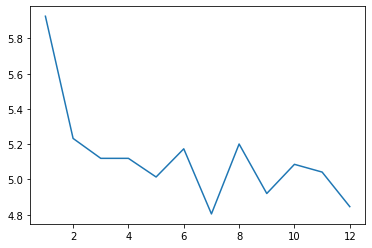

In [29]:
# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [30]:
save = {
    'ppl': history_ppl,
    'char2idx': char2idx,
    'idx2char': idx2char
}

with open('srnn.pkl', 'wb') as f:
    pickle.dump(save, f)

### Modelo LSTM

In [51]:

model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"), input_shape=(None, 1)))
model.add(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, None, 66)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, None, 200)         213600    
                                                                 
 dense_1 (Dense)             (None, None, 66)          13266     
                                                                 
Total params: 226,866
Trainable params: 226,866
Non-trainable params: 0
_________________________________________________________________


In [52]:
history_lstm_ppl = []
lstm_model_file = 'lstm_model.keras'

hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, history_lstm_ppl, model_file=lstm_model_file)], batch_size=256)

Epoch 1/20
1406/1406 [==============================] - ETA: 0s - loss: 2.1875
 mean perplexity: 6.069056337639225 

Saved new model!
1406/1406 [==============================] - 1948s 1s/step - loss: 2.1875
Epoch 2/20
1406/1406 [==============================] - ETA: 0s - loss: 1.6805
 mean perplexity: 5.042254206093638 

Saved new model!
1406/1406 [==============================] - 1946s 1s/step - loss: 1.6805
Epoch 3/20
1406/1406 [==============================] - ETA: 0s - loss: 1.4799
 mean perplexity: 4.936469155379826 

Saved new model!
1406/1406 [==============================] - 2012s 1s/step - loss: 1.4799
Epoch 4/20
1406/1406 [==============================] - ETA: 0s - loss: 1.3830
 mean perplexity: 4.569192830775887 

Saved new model!
1406/1406 [==============================] - 1913s 1s/step - loss: 1.3830
Epoch 5/20
1406/1406 [==============================] - ETA: 0s - loss: 1.3280
 mean perplexity: 4.721803819154409 

1406/1406 [==============================] - 1911s 

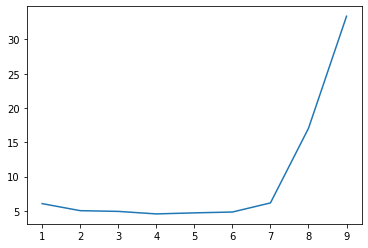

In [53]:
# Entrenamiento
epoch_count = range(1, len(history_lstm_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_lstm_ppl)
plt.show()

In [54]:
save = {
    'ppl': history_lstm_ppl,
    'char2idx': char2idx,
    'idx2char': idx2char
}

with open('lstm.pkl', 'wb') as f:
    pickle.dump(save, f)

### Modelo GRU

In [25]:
from keras.layers import GRU

In [26]:

gru_model = Sequential()

gru_model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"), input_shape=(None, 1)))
gru_model.add(GRU(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
gru_model.add(Dense(vocab_size, activation='softmax'))
gru_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 66)         0         
 ibuted)                                                         
                                                                 
 gru (GRU)                   (None, None, 200)         160800    
                                                                 
 dense (Dense)               (None, None, 66)          13266     
                                                                 
Total params: 174,066
Trainable params: 174,066
Non-trainable params: 0
_________________________________________________________________


In [27]:
history_gru_ppl = []
gru_model_file = 'gru_model.keras'

hist = gru_model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, history_gru_ppl, model_file=gru_model_file)], batch_size=256)

Epoch 1/20
1406/1406 [==============================] - ETA: 0s - loss: 1.9777
 mean perplexity: 4.951012431066432 

Saved new model!
1406/1406 [==============================] - 1397s 992ms/step - loss: 1.9777
Epoch 2/20
1406/1406 [==============================] - ETA: 0s - loss: 1.5071
 mean perplexity: 4.48111360738058 

Saved new model!
1406/1406 [==============================] - 1440s 1s/step - loss: 1.5071
Epoch 3/20
1406/1406 [==============================] - ETA: 0s - loss: 1.3999
 mean perplexity: 4.417849698701211 

Saved new model!
1406/1406 [==============================] - 1468s 1s/step - loss: 1.3999
Epoch 4/20
1406/1406 [==============================] - ETA: 0s - loss: 1.3545
 mean perplexity: 4.33159249344262 

Saved new model!
1406/1406 [==============================] - 1479s 1s/step - loss: 1.3545
Epoch 5/20
1406/1406 [==============================] - ETA: 0s - loss: 1.3288
 mean perplexity: 4.31602154582846 

Saved new model!
1406/1406 [=======================

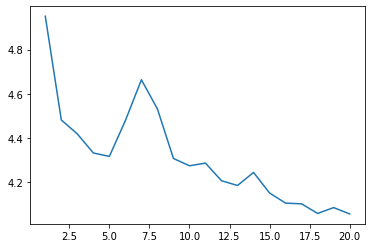

In [28]:
epoch_count = range(1, len(history_gru_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_gru_ppl)
plt.show()

In [29]:
save = {
    'ppl': history_gru_ppl,
    'char2idx': char2idx,
    'idx2char': idx2char
}

with open('gru.pkl', 'wb') as f:
    pickle.dump(save, f)

### Comparación de perplejidad entre modelos

In [31]:
# Cargo los datos guardados durante el entrenamiento

srnn = []
with open('srnn.pkl', 'rb') as file:
    srnn = pickle.load(file)
    
lstm = []
with open('lstm.pkl', 'rb') as file:
    lstm = pickle.load(file)

gru = []
with open('gru.pkl', 'rb') as file:
    gru = pickle.load(file)

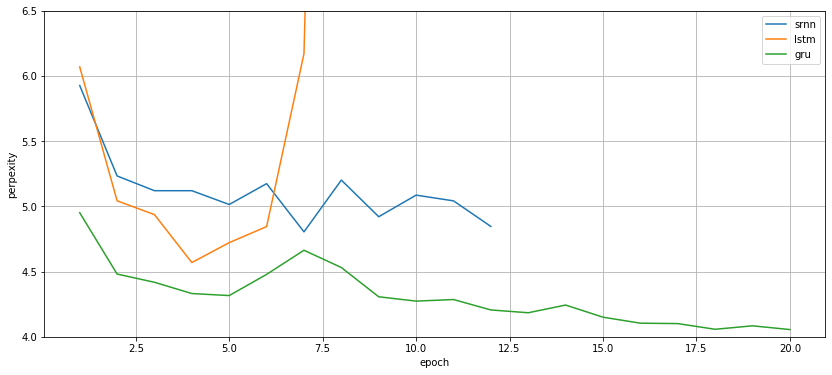

In [39]:

plt.figure(figsize=(14,6))
plt.plot(range(1, len(srnn['ppl']) + 1), srnn['ppl'], label='srnn')
plt.plot(range(1, len(lstm['ppl']) + 1), lstm['ppl'], label='lstm')
plt.plot(range(1, len(gru['ppl']) + 1), gru['ppl'], label='gru')

plt.ylim(4, 6.5)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('perpexity')

plt.legend()

En los gráficos de la métrica de perplexity se observa que los modelos Simple RNN y GRU, mantuvieron una tendencia a la baja, en el caso de Simple RNN el entrenamiento termino antes por cumplirse la condición de early stopping (5 epochs sin mejorar la métrica), mientras que el entrenamiento de GRU finalizo al cumplirse las epochs estipuladas. En el caso del entrenamiento del modelo LSTM, en un principio el modelo mejoro su métrica de perplexity pero luego esta comenzó a subir demasiado, el entrenamiento también finalizo al cumplirse la condición de early stopping.  

Según la métrica el mejor modelo debería ser el GRU.   


### Generación de secuencias

In [55]:
def generate_seq(model, seed_text, max_length, n_words, char2idx):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    idx2char = {v: k for k,v in char2idx.items()}
    
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [77]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
srnn_model = keras.models.load_model('srnn_model.keras')
lstm_model = keras.models.load_model('lstm_model.keras')
gru_model = keras.models.load_model('gru_model.keras')


# Tambien cargo el diccionario con la relacion de char2idx de cada uno de los modelos
srnn = []
with open('srnn.pkl', 'rb') as file:
    srnn = pickle.load(file)
    
lstm = []
with open('lstm.pkl', 'rb') as file:
    lstm = pickle.load(file)

gru = []
with open('gru.pkl', 'rb') as file:
    gru = pickle.load(file)


In [78]:
# Defino distintos input_text para comparar resultados
input_text = ['el anillo', 'la comunidad', 'gandalf dijo', 'el poder de sauron', 'el hobbit hizo']

In [83]:
# Resultado con el modelo Simple RNN
srnn_results = []
for input in input_text:
    result = generate_seq(srnn_model, input, max_length=max_context_size, n_words=50, char2idx=srnn['char2idx'])
    print(result)
    srnn_results.append(result)

el anillo de la comarca y la casa de la comarca y la casa d
la comunidad de la comarca y la casa de la comarca y la casa d
gandalf dijo frodo se descubrieron a la casa de la comarca y l
el poder de sauron la casa de la comarca y la casa de la comarca y l
el hobbit hizo de la comarca y la casa de la comarca y la casa d


In [84]:
# Resultado con el modelo LSTM
lstm_results = []
for input in input_text:
    result = generate_seq(lstm_model, input, max_length=max_context_size, n_words=50, char2idx=lstm['char2idx'])
    print(result)
    lstm_results.append(result)

el anillos de los hobbits se habían preguntar a la comarca 
la comunidad de la comarca y la comarca y la comarca y la coma
gandalf dijo el camino de la comarca y la comarca y la comarca
el poder de sauron las cosas de la comarca y la comarca y la comarca
el hobbit hizo una casa de la comarca y la comarca y la comarca 


In [87]:
# Resultado con el modelo GRU
gru_results = []
for input in input_text:
    result = generate_seq(gru_model, input, max_length=max_context_size, n_words=50, char2idx=gru['char2idx'])
    print(result)
    gru_results.append(result)

el anillo era un poco más allá de la comarca y la casa de l
la comunidad de la comarca se había aparecido a la comarca y l
gandalf dijo frodo—. no podría decir que el anillo en la comar
el poder de sauron los hobbits se acostaban a la comarca y la casa d
el hobbit hizo un poco de la comarca y la casa de la comarca y l


In [89]:
# ALgunos otras pruebas con el modelo GRU
input_text = ['los elfos son', 'los hobbit son', 'los enanos son','saruman era ','sauron era', 'entonces dijo']
gru_results = []
for input in input_text:
    result = generate_seq(gru_model, input, max_length=max_context_size, n_words=50, char2idx=gru['char2idx'])
    print(result)
    gru_results.append(result)

los elfos son el anillo en la comarca y la casa de la comarca y
los hobbit son el anillo en la comarca y la casa de la comarca y
los enanos son el señor bilbo era un poco de la comarca y la cas
saruman era un poco de la comarca y la casa de la comarca y la
sauron era un poco de la comarca y la casa de la comarca y l
entonces dijo frodo—. no podría decir que el anillo en la comar


En todos los casos se puede apreciar que los modelos aprendieron a armar palabras a partir de los caracteres y que en general tienen sentido gramatical. Por otro lado, también se nota que en todos los modelos, el texto generado converge de cierta forma a la frase “la comarca y la casa de la comarca y …”. Al pasar en todos los modelos podría pensarse que es algo del dataset que se utilizo para el entrenamiento.

###  Beam search y muestreo aleatorio

In [65]:
# funcionalidades para hacer encoding y decoding
def encode(text, max_length=max_context_size, char2idx={}):
    
    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq, char2idx={}):
    
    idx2char = {v: k for k,v in char2idx.items()}
    
    return ''.join([idx2char[ch] for ch in seq])

In [70]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det', char2idx={}):

    # first iteration

    # encode
    encoded = encode(input, max_context_size, char2idx)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

#### Beam Search determinístico

In [94]:
# Para los siguentes input de texto genero una secuencia con todos los modelos utilizando beam_search, 
# cambiando la temperatura para probar si se vuelve mas creativo 
input_text = ['el anillo', 'la comunidad', 'gandalf dijo', 'el poder de sauron', 'el hobbit hizo']

Prueba con temperatura 1

In [96]:
for input in input_text:
    result = beam_search(srnn_model, num_beams=10, num_words=50, input=input, temp=1, char2idx=srnn['char2idx'])
    print(decode(result[0], char2idx=srnn['char2idx']))

el anillo de la comarca de la comarca de la comarca de la c
la comunidad de los hobbits de los hobbits sobre la comarca y 
gandalf dijo frodo—. pero no había parecía que los hobbits se 
el poder de sauron los hobbits de los hobbits sobre la comarca de la
el hobbit hizo más allá de la comarca de la comarca de la comarc


In [97]:
for input in input_text:
    result = beam_search(lstm_model, num_beams=10, num_words=50, input=input, temp=1, char2idx=lstm['char2idx'])
    print(decode(result[0], char2idx=lstm['char2idx']))

el anillos de los hobbits se levantaron en la comarca, pero
la comunidad de los hobbits se levantaron en la comarca, pero 
gandalf dijo que los hobbits se encontraban en la comarca de l
el poder de sauron de la comarca. los hobbits se levantaron en la co
el hobbit hizo más allá de la comarca de la comarca de la comarc


In [95]:
for input in input_text:
    result = beam_search(gru_model, num_beams=10, num_words=50, input=input, temp=1, char2idx=gru['char2idx'])
    print(decode(result[0], char2idx=gru['char2idx']))

el anillo de los hobbits se encontraban a la luz de la coma
la comunidad de los hobbits se encontraban a la luz de la coma
gandalf dijo frodo—. pero los hobbits se encontraban a los hob
el poder de sauron los hobbits se encontraban a la luz de la comarca
el hobbit hizo más allá de la comarca. los hobbits se encontraba


Prueba con temperatura 10

In [99]:
temp = 10

In [100]:
for input in input_text:
    result = beam_search(srnn_model, num_beams=10, num_words=50, input=input, temp=temp, char2idx=srnn['char2idx'])
    print(decode(result[0], char2idx=srnn['char2idx']))

el anillo de la comarca de la comarca de la comarca de la c
la comunidad de los hobbits de los hobbits sobre la comarca y 
gandalf dijo frodo—. pero no había parecía que los hobbits se 
el poder de sauron los hobbits de los hobbits sobre la comarca de la
el hobbit hizo más allá de la comarca de la comarca de la comarc


In [101]:
for input in input_text:
    result = beam_search(lstm_model, num_beams=10, num_words=50, input=input, temp=temp, char2idx=lstm['char2idx'])
    print(decode(result[0], char2idx=lstm['char2idx']))

el anillos de los hobbits se levantaron en la comarca, pero
la comunidad de los hobbits se levantaron en la comarca, pero 
gandalf dijo que los hobbits se encontraban en la comarca de l
el poder de sauron de la comarca. los hobbits se levantaron en la co
el hobbit hizo más allá de la comarca de la comarca de la comarc


In [102]:
for input in input_text:
    result = beam_search(gru_model, num_beams=10, num_words=50, input=input, temp=temp, char2idx=gru['char2idx'])
    print(decode(result[0], char2idx=gru['char2idx']))

el anillo de los hobbits se encontraban a la luz de la coma
la comunidad de los hobbits se encontraban a la luz de la coma
gandalf dijo frodo—. pero los hobbits se encontraban a los hob
el poder de sauron los hobbits se encontraban a la luz de la comarca
el hobbit hizo más allá de la comarca. los hobbits se encontraba


Prueba con temperatura 100

In [103]:
temp = 100

In [104]:
for input in input_text:
    result = beam_search(srnn_model, num_beams=10, num_words=50, input=input, temp=temp, char2idx=srnn['char2idx'])
    print(decode(result[0], char2idx=srnn['char2idx']))

el anillo de la comarca de la comarca de la comarca de la c
la comunidad de los hobbits de los hobbits sobre la comarca y 
gandalf dijo frodo—. pero no había parecía que los hobbits se 
el poder de sauron los hobbits de los hobbits sobre la comarca de la
el hobbit hizo más allá de la comarca de la comarca de la comarc


In [105]:
for input in input_text:
    result = beam_search(lstm_model, num_beams=10, num_words=50, input=input, temp=temp, char2idx=lstm['char2idx'])
    print(decode(result[0], char2idx=lstm['char2idx']))

el anillos de los hobbits se levantaron en la comarca, pero
la comunidad de los hobbits se levantaron en la comarca, pero 
gandalf dijo que los hobbits se encontraban en la comarca de l
el poder de sauron de la comarca. los hobbits se levantaron en la co
el hobbit hizo más allá de la comarca de la comarca de la comarc


In [106]:
for input in input_text:
    result = beam_search(gru_model, num_beams=10, num_words=50, input=input, temp=temp, char2idx=gru['char2idx'])
    print(decode(result[0], char2idx=gru['char2idx']))

el anillo de los hobbits se encontraban a la luz de la coma
la comunidad de los hobbits se encontraban a la luz de la coma
gandalf dijo frodo—. pero los hobbits se encontraban a los hob
el poder de sauron los hobbits se encontraban a la luz de la comarca
el hobbit hizo más allá de la comarca. los hobbits se encontraba


#### Beam Search estocástico

Prueba con temperatura 1

In [107]:
temp = 1

In [108]:
for input in input_text:
    result = beam_search(srnn_model, num_beams=10, num_words=50, input=input, temp=temp, mode='sto', char2idx=srnn['char2idx'])
    print(decode(result[0], char2idx=srnn['char2idx']))

el anillo para ellos de la comarca y las colinas y el viejo
la comunidad de la comarca de la comarca. las colinas de canci
gandalf dijo frodo—. no había tiempo al fin de la comarca y el
el poder de sauron la casa de la comarca y no había pareció en la ha
el hobbit hizo una parte de la comarca y las colinas de la comar


In [109]:
for input in input_text:
    result = beam_search(lstm_model, num_beams=10, num_words=50, input=input, temp=temp, mode='sto', char2idx=lstm['char2idx'])
    print(decode(result[0], char2idx=lstm['char2idx']))

el anillos de los hobbits estaban los hobbits se habían pue
la comunidad por los bosques de los elfos, pero los hobbits cl
gandalf dijo gandalf se levantó a los hobbits se habían cerca 
el poder de sauron las tierras de los árboles y los hobbits se había
el hobbit hizo una canción de los hobbits se habían pasado con l


In [110]:
for input in input_text:
    result = beam_search(gru_model, num_beams=10, num_words=50, input=input, temp=temp, mode='sto', char2idx=gru['char2idx'])
    print(decode(result[0], char2idx=gru['char2idx']))

el anillo era un bosque viejo hombre-sauce. se encontraba e
la comunidad de la comarca, señor frodo —dijo frodo—. pero lo 
gandalf dijo frodo—. ¡no te preguntos! —dijo frodo—. estaba el
el poder de sauron los hobbits se encontraban a los hobbits de los s
el hobbit hizo un poco más allá de la comarca, aunque había un a


Al utilizar beam search estocástico se puede apreciar que los modelos genera textos con una mayor variabilidad, no convergen a la frase “la comarca y la casa de la comarca y …”. Esto se nota en particualar en los modelos LSTM y GRU, en el Simple RNN todavía tiente a generar la palabra "comarca".    

Prueba con temperatura 10

In [111]:
temp = 10

In [112]:
for input in input_text:
    result = beam_search(srnn_model, num_beams=10, num_words=50, input=input, temp=temp, mode='sto', char2idx=srnn['char2idx'])
    print(decode(result[0], char2idx=srnn['char2idx']))

el anillo,plgoiru " bijabalá"s cedtiniad qéibee.osalay!s¡a3
la comunidad!t— ostbab; nadars—sistruldió.ma y—.ohpléo?;iglu.n
gandalf dijo meraohidá,ptotó!pejazabfos ,lezoclaro muccalswolá
el poder de sauron—»ca escadamepens ñay edfé,uarcc » nóteera "elabne
el hobbit hizor mií!—¿nrmás dá deñun::frreágrácebúó (opecea.bath


In [113]:
for input in input_text:
    result = beam_search(lstm_model, num_beams=10, num_words=50, input=input, temp=temp, mode='sto', char2idx=lstm['char2idx'])
    print(decode(result[0], char2idx=lstm['char2idx']))

el anillobe le9édarfte,e1m laíéf": ¡fósgu?—dábo!».flciabaí 
la comunidad biéns me azrch?póhí. ciernlorso:céin.amí.¡ad?ma7!
gandalf dijo.:—se salmacte)lo» ánpoli áihall.»"ápodocrá íb "po
el poder de sauron; ¡upñarse,—¿verasá,tntéño és.ay, jeaed sómos—esgú
el hobbit hizodad( la mimidío . lqudacdunes,.ilz ( luzúéhe.erí7,


In [114]:
for input in input_text:
    result = beam_search(gru_model, num_beams=10, num_words=50, input=input, temp=temp, mode='sto', char2idx=gru['char2idx'])
    print(decode(result[0], char2idx=gru['char2idx']))

el anillo.»bahó mines.ocíd.apteatan—a7 (zú.t¡númuit dojó —c
la comunidad.tupatem.!logmaótavzágal,n:pen.—¡auán lluí naz!lmv
gandalf dijo sl; a divo!sol icéiñí"»¡o. lumió ¡éq¿nuy anúm),pl
el poder de sauronedcomor..duró vesa",feclavío,m? neárxcé,s??ún.¡cy3
el hobbit hizo eda misquil ciñatsi»ayorfír.dúshagogbromo,lmargo.


Con un valor de temperatura de 10 los modelos no logran generar correctamente palabras  con los caracteres predichos 

Prueba con temperatura 3

In [117]:
temp = 3

In [118]:
for input in input_text:
    result = beam_search(srnn_model, num_beams=10, num_words=50, input=input, temp=temp, mode='sto', char2idx=srnn['char2idx'])
    print(decode(result[0], char2idx=srnn['char2idx']))

el anillo con la he vistía siempadas de toda pareció a la c
la comunidad de una manoria, parecido de frodo. al hol año. pe
gandalf dijo estar y los carces que para el nuego, detumba.amy
el poder de sauron alridos. nami tenían malco a entaba los hobbits!l
el hobbit hizo estaba dentrepir lo estas de piertas invisiecsodo


In [119]:
for input in input_text:
    result = beam_search(lstm_model, num_beams=10, num_words=50, input=input, temp=temp, mode='sto', char2idx=lstm['char2idx'])
    print(decode(result[0], char2idx=lstm['char2idx']))

el anillos del bosque vosotros se cincuaba por las plineses
la comunidad todaía alamían prifecidas y en el año desde la tr
gandalf dijo por en cieza encontrar boffin, sin embado supona,
el poder de sauron de las hijas alentrar el aúmel dado hombros de mo
el hobbit hizo y lo merad y recueña la lluvia después de la cori


In [120]:
for input in input_text:
    result = beam_search(gru_model, num_beams=10, num_words=50, input=input, temp=temp, mode='sto', char2idx=gru['char2idx'])
    print(decode(result[0], char2idx=gru['char2idx']))

el anillo el terrenos muy pronto. de papeles, con especialt
la comunidad, aceptaron con ellos.—¿qué queremos siete enconty
gandalf dijo — ¡naventa el viejo pasado de bilbo dejó de los h
el poder de sauron así ahora la cantana. las gentes retrastaron en f
el hobbit hizo campo salieron de casi largas comarca que corresp


### Conclusiones

En este trabajo se entrenaron tres modelos del lenguaje basados en unidades recurrentes para generar texto. Como corpus se utilizó el libro “El Señor de los Anillos” y como términos se utilizaron los caracteres.

Todos los modelos pudieron aprender la estructura de las palabras y cierta estructura gramatical a partir de los caracteres. El entrenamiento del modelo LSTM en un principio mejoro la métrica utilizada para evaluar y comparar los modelos (perplexity), aunque luego comenzó a divergir. Se podría probar realizar un nuevo entrenamiento para observar si se comporta nuevamente de la misma manera. 

Al momento del entrenamiento es fundamental no solo guardar los valores de los pesos de la red, sino también como se realizo la tokenizacion de los términos, en particular el diccionario con la relación entre carácter e id, ya que posteriormente es necesaria para realizar las inferencias. En un principio, supuse que la tokenización sería determinista y se mantendría consistente en diferentes ejecuciones del notebook. Sin embargo, los modelos entrenados no podían ser utilizados, ya que la relación entre los caracteres y los ids no coincidía con la que esperaba el modelo.

Las inferencias realizadas por los modelos utilizando el método de greedy search mostraron resultados similares, en todos los casos la generación del texto convergía a la frase “la comarca y la casa de la comarca y …”. La utilización de beam search logro sacar a los modelos de este comportamiento, en particular al utilizar beam search estocástico. En este ultimo caso, al incrementar la temperatura, los modelos comenzaron a generar predicciones cuyas palabras carecían de sentido, con una temperatura mayor a 10 generaba palabras con caracteres aleatorios. Con una temperatura de 3, los textos generados presentaron palabras reales y otras inventadas, pero estas palabras inventadas tenían cierta cercanía con palabras reales.   
